In [19]:
import numpy as np
import requests
import json
from collections import namedtuple
from PIL import Image
import os

import matplotlib.pyplot as plt
from matplotlib.image import imread

import tqdm
import torch
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST, MNIST
from tqdm.notebook import tqdm, trange
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset

from transformers import AutoFeatureExtractor, ViTForImageClassification
import torch.nn.functional as F

! pip install torchsummary
from torchsummary import summary

! pip install transformers

In [20]:
import kagglehub

path = kagglehub.dataset_download("kasikrit/att-database-of-faces")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/att-database-of-faces


In [21]:
face_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

class ORLFacesDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_subjects=40, max_samples=None):
        self.images = []
        self.labels = []
        self.transform = transform
        sample_count = 0

        for subject_id in range(1, max_subjects + 1):
            subject_dir = os.path.join(root_dir, f"s{subject_id}")
            if not os.path.isdir(subject_dir):
                continue
            for img_name in os.listdir(subject_dir):
                if img_name.endswith(".pgm"):
                    self.images.append(os.path.join(subject_dir, img_name))
                    self.labels.append(subject_id - 1)
                    sample_count += 1
                    if max_samples and sample_count >= max_samples:
                        break
            if max_samples and sample_count >= max_samples:
                break

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

dataset_root = path

attacker_dataset_train = ORLFacesDataset(
    dataset_root, transform=face_transform, max_subjects=36, max_samples=10000
)

attacker_dataset_test = ORLFacesDataset(
    dataset_root, transform=face_transform, max_subjects=36, max_samples=100
)


In [22]:
def filter_and_limit_dataset(dataset, max_label=35, max_samples=None):
    filtered_images = []
    filtered_labels = []

    for img_path, label in zip(dataset.images, dataset.labels):
        if label <= max_label:
            filtered_images.append(img_path)
            filtered_labels.append(label)
            if max_samples and len(filtered_labels) >= max_samples:
                break

    dataset.images = filtered_images
    dataset.labels = filtered_labels

filter_and_limit_dataset(attacker_dataset_train, max_label=35, max_samples=10000)
filter_and_limit_dataset(attacker_dataset_test, max_label=35, max_samples=100)


In [23]:
attacker_loader_train = torch.utils.data.DataLoader(attacker_dataset_train, batch_size=64)
attacker_loader_test = torch.utils.data.DataLoader(attacker_dataset_test, batch_size=64)

In [24]:
def plot_images(tensors):
    fig = plt.figure(figsize=(10, 5))
    n_tensors = len(tensors)
    for i in range(n_tensors):
        ax = fig.add_subplot(1, n_tensors, i + 1)
        img = tensors[i].squeeze(0)
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    plt.tight_layout()
    plt.show()


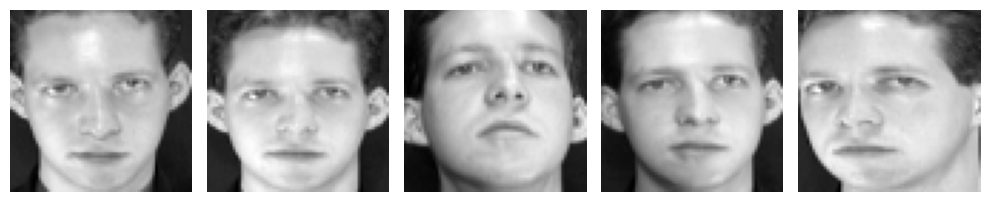

In [25]:
def plot_data(data_loader):
    images = []
    for _, (data, _) in enumerate(data_loader):
        for i in range(5):
            images.append(data[i])
        break
    plot_images(images)

plot_data(attacker_loader_train)


In [26]:
print("Loading DeiT model")
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-base-patch16-224')
deit_model = ViTForImageClassification.from_pretrained('facebook/deit-base-patch16-224')
deit_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deit_model = deit_model.to(device)
print(f"Model loaded on {device}")

def classify_image_local(image_tensor):
    try:
        if image_tensor.dim() == 3 and image_tensor.size(0) == 1:
            image_tensor = image_tensor.expand(3, -1, -1)

        image_pil = transforms.ToPILImage()(image_tensor.cpu())

        inputs = feature_extractor(images=image_pil, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = deit_model(**inputs)
            logits = outputs.logits
            probabilities = F.softmax(logits, dim=-1)

        return probabilities.squeeze().cpu().numpy()

    except Exception as e:
        print(f"[!] Classification error: {e}")
        return np.zeros(1000)

Loading DeiT model


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Model loaded on cpu


In [27]:
class TargetModel(torch.nn.Module):
    def __init__(self, output_dim=1000):
        super().__init__()
        self.output_dim = output_dim

    def forward(self, x):
        outputs = []

        for i in range(x.shape[0]):
            img = x[i].detach().cpu()

            probs_1000 = classify_image_local(img)

            outputs.append(probs_1000)

        return torch.tensor(np.array(outputs), dtype=torch.float32)

In [28]:
def get_target_labels_local(loader, output_dim=1000):
    target_model = TargetModel(output_dim=output_dim)
    all_targets = []

    print("Generating target labels")
    for batch_idx, (batch, _) in enumerate(loader):
        if batch_idx % 10 == 0:
            print(f"Processing batch {batch_idx}/{len(loader)}")

        targets = target_model(batch)
        all_targets.append(targets)

    return torch.cat(all_targets, dim=0)

In [29]:
print("Generating training targets")
attacker_targets_train = get_target_labels_local(attacker_loader_train, output_dim=1000)
print("Generating test targets")
attacker_targets_test = get_target_labels_local(attacker_loader_test, output_dim=1000)

print(f"Train targets shape: {attacker_targets_train.shape}")
print(f"Test targets shape: {attacker_targets_test.shape}")

np.savez('./labels_train.npz', attacker_targets_train.numpy())
np.savez('./labels_test.npz', attacker_targets_test.numpy())

print("Target labels generated and saved successfully!")

Generating training targets
Generating target labels
Processing batch 0/6
Generating test targets
Generating target labels
Processing batch 0/2
Train targets shape: torch.Size([360, 1000])
Test targets shape: torch.Size([100, 1000])
Target labels generated and saved successfully!


In [30]:
def reconstruct_samples(model):
    images = []

    batch_size = 64

    for batch, (data, _) in enumerate(attacker_loader_train):
        targets = attacker_targets_train[batch * batch_size: (batch + 1) * batch_size].float()

        for i in range(2):
            with torch.no_grad():
                reconstructed_image = model(torch.unsqueeze(targets[i], 0).cuda()).squeeze(0)

            images.append(data[i])
            images.append(reconstructed_image.cpu())
        break

    for batch, (data, _) in enumerate(attacker_loader_test):
        targets = attacker_targets_test[batch * batch_size: (batch + 1) * batch_size].float()

        for i in range(2):
            with torch.no_grad():
                reconstructed_image = model(torch.unsqueeze(targets[i], 0).cuda()).squeeze(0)

            images.append(data[i])
            images.append(reconstructed_image.cpu())
        break

    plot_images(images)


In [31]:
class AttackModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1000, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(256, 16*16*8),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (8, 16, 16)),

            torch.nn.ConvTranspose2d(8, 4, 3, padding=1, stride=2, output_padding=1),
            torch.nn.BatchNorm2d(4),
            torch.nn.ReLU(),

            torch.nn.ConvTranspose2d(4, 2, 3, padding=1, stride=2, output_padding=1),
            torch.nn.BatchNorm2d(2),
            torch.nn.ReLU(),

            torch.nn.ConvTranspose2d(2, 1, 3, padding=1, stride=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

attacker = AttackModel()
summary(attacker, (1000, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         512,512
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                 [-1, 2048]         526,336
              ReLU-8                 [-1, 2048]               0
         Unflatten-9            [-1, 8, 16, 16]               0
  ConvTranspose2d-10            [-1, 4, 32, 32]             292
      BatchNorm2d-11            [-1, 4, 32, 32]               8
             ReLU-12            [-1, 4, 32, 32]               0
  ConvTranspose2d-13            [-1, 2, 64, 64]              74
      BatchNorm2d-14            [-1, 2,

In [32]:
def attack(attack_model):
    images = []

    for idx in range(6):
        target_output = np.random.exponential(0.1, 1000)
        target_output = target_output / target_output.sum()

        with torch.no_grad():
            reconstructed_image = attack_model(torch.tensor([target_output]).float().cuda()).squeeze(0)

        images.append(reconstructed_image.cpu())

    plot_images(images)

In [33]:
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attacker = AttackModel().to(device)

hyperparams = namedtuple('hyperparams', 'batch_size,epochs,learning_rate')

attacker_hyperparams = hyperparams(
    batch_size=64,
    epochs=200,
    learning_rate=1e-3,
)

attacker_loader_train = torch.utils.data.DataLoader(attacker_dataset_train, batch_size=attacker_hyperparams.batch_size)
attack_optim = torch.optim.Adam(attacker.parameters(), lr=attacker_hyperparams.learning_rate, weight_decay=1e-4)
scheduler = StepLR(attack_optim, step_size=50, gamma=0.5)

for epoch in trange(attacker_hyperparams.epochs):
    epoch_loss = 0.0

    for batch, (data, _) in enumerate(attacker_loader_train):
        data = data.float().to(device)

        if torch.cuda.is_available() and not (epoch % 20) and not batch:
            reconstruct_samples(attacker)
            attack(attacker)

        targets = attacker_targets_train[
            batch * attacker_hyperparams.batch_size :
            (batch + 1) * attacker_hyperparams.batch_size
        ].float().to(device)

        attack_optim.zero_grad()
        output = attacker(targets)

        mse_loss = ((output - data)**2).mean()
        l1_loss = torch.abs(output - data).mean()
        loss = mse_loss + 0.1 * l1_loss

        loss.backward()
        attack_optim.step()
        epoch_loss += output.shape[0] * loss.item()

    print(f"Epoch {epoch}, Loss: {epoch_loss / len(attacker_dataset_train):.4f}")
    scheduler.step()

print('Finished Training')

if torch.cuda.is_available():
    attack(attacker)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 0.0649
Epoch 1, Loss: 0.0593
Epoch 2, Loss: 0.0566
Epoch 3, Loss: 0.0544
Epoch 4, Loss: 0.0523
Epoch 5, Loss: 0.0500
Epoch 6, Loss: 0.0475
Epoch 7, Loss: 0.0452
Epoch 8, Loss: 0.0434
Epoch 9, Loss: 0.0423
Epoch 10, Loss: 0.0415
Epoch 11, Loss: 0.0410
Epoch 12, Loss: 0.0405
Epoch 13, Loss: 0.0401
Epoch 14, Loss: 0.0397
Epoch 15, Loss: 0.0392
Epoch 16, Loss: 0.0389
Epoch 17, Loss: 0.0385
Epoch 18, Loss: 0.0382
Epoch 19, Loss: 0.0378
Epoch 20, Loss: 0.0375
Epoch 21, Loss: 0.0372
Epoch 22, Loss: 0.0370
Epoch 23, Loss: 0.0368
Epoch 24, Loss: 0.0366
Epoch 25, Loss: 0.0363
Epoch 26, Loss: 0.0361
Epoch 27, Loss: 0.0359
Epoch 28, Loss: 0.0357
Epoch 29, Loss: 0.0356
Epoch 30, Loss: 0.0353
Epoch 31, Loss: 0.0352
Epoch 32, Loss: 0.0350
Epoch 33, Loss: 0.0349
Epoch 34, Loss: 0.0348
Epoch 35, Loss: 0.0346
Epoch 36, Loss: 0.0344
Epoch 37, Loss: 0.0343
Epoch 38, Loss: 0.0343
Epoch 39, Loss: 0.0341
Epoch 40, Loss: 0.0340
Epoch 41, Loss: 0.0339
Epoch 42, Loss: 0.0338
Epoch 43, Loss: 0.033

In [34]:
def reconstruct_samples(model):
    images = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    batch_size = 64

    for batch, (data, _) in enumerate(attacker_loader_train):
        targets = attacker_targets_train[batch * batch_size: (batch + 1) * batch_size].float().to(device)

        for i in range(2):
            with torch.no_grad():
                reconstructed_image = model(torch.unsqueeze(targets[i], 0)).squeeze(0)

            images.append(data[i])
            images.append(reconstructed_image.cpu())
        break

    for batch, (data, _) in enumerate(attacker_loader_test):
        targets = attacker_targets_test[batch * batch_size: (batch + 1) * batch_size].float().to(device)

        for i in range(2):
            with torch.no_grad():
                reconstructed_image = model(torch.unsqueeze(targets[i], 0)).squeeze(0)

            images.append(data[i])
            images.append(reconstructed_image.cpu())
        break

    plot_images(images)

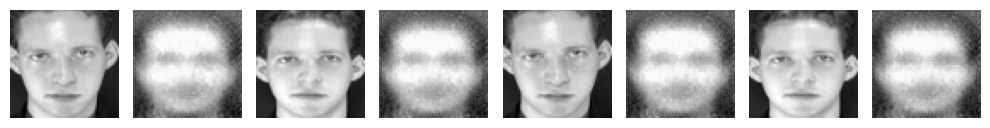

In [35]:
reconstruct_samples(attacker)


In [36]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_reconstruction(model):
    model.eval()
    total_ssim = 0
    total_psnr = 0
    count = 0

    for batch, (data, _) in enumerate(attacker_loader_test):
        targets = attacker_targets_test[batch * 64: (batch + 1) * 64].float().to(device)
        data = data.to(device)

        with torch.no_grad():
            output = model(targets)

        for i in range(output.shape[0]):
            real = data[i].squeeze().cpu().numpy()
            recon = output[i].squeeze().cpu().numpy()
            total_ssim += ssim(real, recon, data_range=1.0)
            total_psnr += psnr(real, recon, data_range=1.0)
            count += 1

    print(f"Average SSIM: {total_ssim / count:.4f}")
    print(f"Average PSNR: {total_psnr / count:.2f} dB")

evaluate_reconstruction(attacker)


Average SSIM: 0.3532
Average PSNR: 16.82 dB
